In [1]:
import os
import pandas as pd
import japanize_matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

os.chdir("../")

RATE_A = "RateA"
RATE_S = "RateS"

df_yorushika = pd.read_csv("csv/ヨルシカ_20231119.csv")
df_greeeen = pd.read_csv("csv/GReeeeN_20231119.csv")
df_yoasobi = pd.read_csv("csv/YOASOBI_20240204.csv")

In [2]:
def preprocess(df_list):
    rates = pd.concat(df_list, axis=0)
    rates = rates.dropna(subset=["numerator_A", "denominator_A", "numerator_S", "denominator_S"])

    rates[RATE_A] = rates.numerator_A / rates.denominator_A
    rates[RATE_S] = rates.numerator_S / rates.denominator_S

    x_max = rates.RateA.max()
    x_min = rates.RateA.min()
    y_max = rates.RateS.max()
    y_min = rates.RateS.min()

    xy_max = max(x_max, y_max)
    xy_max += xy_max / xy_max / 100
    xy_min = min(x_min, y_min)
    xy_min -= xy_min / xy_min / 100

    return (rates, xy_min, xy_max)

In [3]:
def scatter(rates:pd.DataFrame, xy_min:int, xy_max:int, subset:list, sort_by:str, xlabel:str, ylabel:str):
    sorted_rates = rates.dropna(subset=subset).sort_values(sort_by, ascending=False)
    center = len(sorted_rates) // 2
    pop_youtube = sorted_rates[:center]
    unpop_youtube = sorted_rates[center:]

    plt.scatter(x=RATE_A, y=RATE_S, data=pop_youtube, color='blue', label='人気曲')
    plt.scatter(x=RATE_A, y=RATE_S, data=unpop_youtube, color='red', label='普通曲')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.xlim(xy_min, xy_max)
    plt.ylim(xy_min, xy_max)
    plt.minorticks_on()
    plt.grid(which='major', color='gray', linestyle='solid')
    plt.grid(which='minor', color='lightgray', linestyle='dotted')

# 単語の一致率

In [4]:
rates, xy_min_wmr, xy_max_wmr = preprocess([
    pd.concat([df_yorushika, pd.read_csv("csv/ヨルシカ_wmr_20231119.csv")], axis=1),
    pd.concat([df_greeeen, pd.read_csv("csv/GReeeeN_wmr_20231119.csv")], axis=1),
    pd.concat([df_yoasobi, pd.read_csv("csv/YOASOBI_wmr_20240204.csv")], axis=1),
])

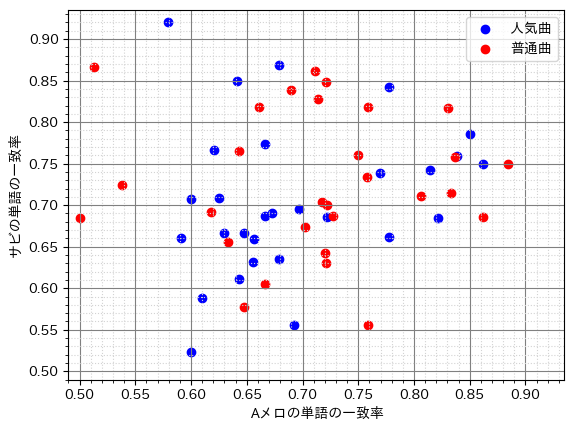

In [5]:
scatter(rates, xy_min_wmr, xy_max_wmr, ["youtube_url"], "youtube_play_times", "Aメロの単語の一致率", "サビの単語の一致率")

# 木構造の類似度（全部分木）

In [6]:
rates, xy_min_ts, xy_max_ts = preprocess([
    pd.concat([df_yorushika, pd.read_csv("csv/ヨルシカ_ts_20231119.csv")], axis=1),
    pd.concat([df_greeeen, pd.read_csv("csv/GReeeeN_ts_20231119.csv")], axis=1),
    pd.concat([df_yoasobi, pd.read_csv("csv/YOASOBI_ts_20240204.csv")], axis=1),
])

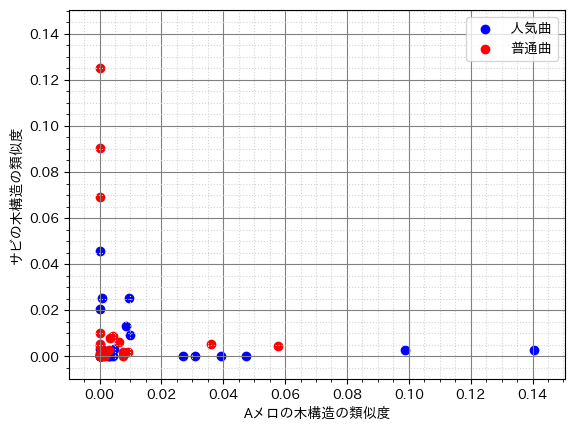

In [7]:
scatter(rates, xy_min_ts, xy_max_ts, ["youtube_url"], "youtube_play_times", "Aメロの木構造の類似度", "サビの木構造の類似度")

# 木構造の類似度計算（親子）

In [8]:
rates, xy_min_tspc, xy_max_tspc = preprocess([
    pd.concat([df_yorushika, pd.read_csv("csv/ヨルシカ_tspc_20231119.csv")], axis=1),
    pd.concat([df_greeeen, pd.read_csv("csv/GReeeeN_tspc_20231119.csv")], axis=1),
    pd.concat([df_yoasobi, pd.read_csv("csv/YOASOBI_tspc_20240204.csv")], axis=1),
])

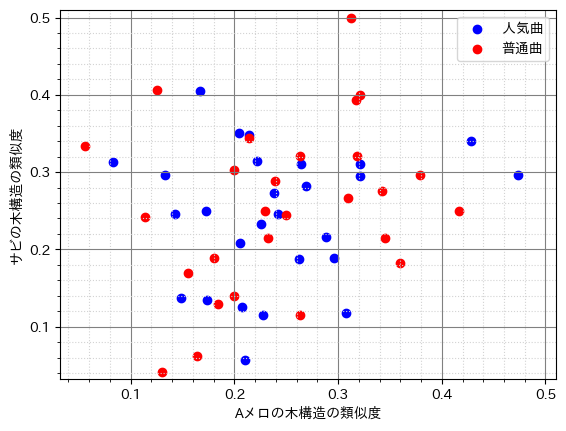

In [9]:
scatter(rates, xy_min_tspc, xy_max_tspc, ["youtube_url"], "youtube_play_times", "Aメロの木構造の類似度", "サビの木構造の類似度")

# 条件比較

/tmp/ipykernel_24056/894088281.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


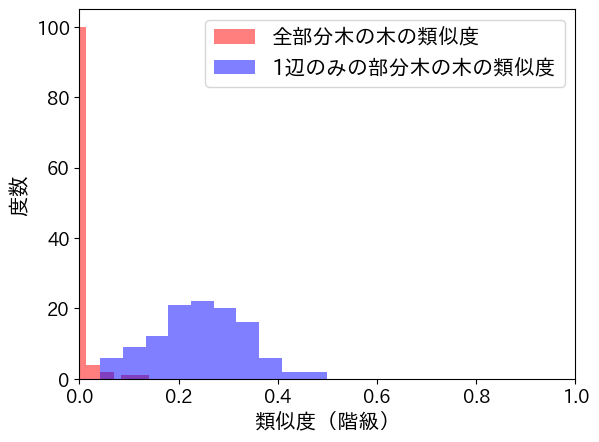

In [10]:
rates_ts, _, _ = preprocess([
    pd.concat([df_yorushika, pd.read_csv("csv/ヨルシカ_ts_20231119.csv")], axis=1),
    pd.concat([df_greeeen, pd.read_csv("csv/GReeeeN_ts_20231119.csv")], axis=1),
    pd.concat([df_yoasobi, pd.read_csv("csv/YOASOBI_ts_20240204.csv")], axis=1),
])
rates_tspc, _, _ = preprocess([
    pd.concat([df_yorushika, pd.read_csv("csv/ヨルシカ_tspc_20231119.csv")], axis=1),
    pd.concat([df_greeeen, pd.read_csv("csv/GReeeeN_tspc_20231119.csv")], axis=1),
    pd.concat([df_yoasobi, pd.read_csv("csv/YOASOBI_tspc_20240204.csv")], axis=1),
])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

hist_ts = list(rates_ts["RateA"]) + list(rates_ts["RateS"])
hist_tspc = list(rates_tspc["RateA"]) + list(rates_tspc["RateS"])

ax.hist(hist_ts, bins=10, color='red', alpha=0.5, label="全部分木の木の類似度")
ax.hist(hist_tspc, bins=10, color='blue', alpha=0.5, label="1辺のみの部分木の木の類似度")
ax.set_xlabel("類似度（階級）", fontsize=15)
ax.set_ylabel("度数", fontsize=15)
plt.legend(fontsize=15)
plt.xlim(0, 1)
plt.tick_params(labelsize=13)
plt.savefig("images/部分木抽出条件の比較.svg")
fig.show()

# 全てのアーティストをそれぞれの人気不人気でまとめる

In [11]:
from scipy import stats

In [12]:
def preprocess(df, csv_path:str):
    rates = pd.merge(df, pd.read_csv(csv_path), on='song')
    rates = rates.dropna(subset=["numerator_A", "denominator_A", "numerator_S", "denominator_S"])

    rates[RATE_A] = rates.numerator_A / rates.denominator_A
    rates[RATE_S] = rates.numerator_S / rates.denominator_S

    x_max = rates.RateA.max()
    x_min = rates.RateA.min()
    y_max = rates.RateS.max()
    y_min = rates.RateS.min()

    xy_max = max(x_max, y_max)
    xy_max += xy_max / xy_max / 100
    xy_min = min(x_min, y_min)
    xy_min -= xy_min / xy_min / 100

    return (rates, xy_min, xy_max)

In [13]:
def scatter(rates_list:list, xy_min:int, xy_max:int, subset:list, sort_by:str, xlabel:str, ylabel:str, img_path:str):
    pop = []
    unpop = []

    for rates in rates_list:
        sorted_rates = rates.dropna(subset=subset).sort_values(sort_by, ascending=False)
        center = len(sorted_rates) // 2
        pop.append(sorted_rates[:center])
        unpop.append(sorted_rates[center:])

    pop_df = pd.concat(pop, axis=0)
    unpop_df = pd.concat(unpop, axis=0)

    plt.scatter(x=RATE_A, y=RATE_S, data=pop_df, color='blue', label='人気曲')
    plt.scatter(x=RATE_A, y=RATE_S, data=unpop_df, color='red', label='普通曲')

    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.legend(fontsize=15)
    plt.xlim(xy_min, xy_max)
    plt.ylim(xy_min, xy_max)
    plt.tick_params(labelsize=13)
    plt.minorticks_on()
    plt.grid(which='major', color='gray', linestyle='solid')
    plt.grid(which='minor', color='lightgray', linestyle='dotted')
    plt.savefig(img_path)

    return [pop_df, unpop_df]

# 単語の一致率

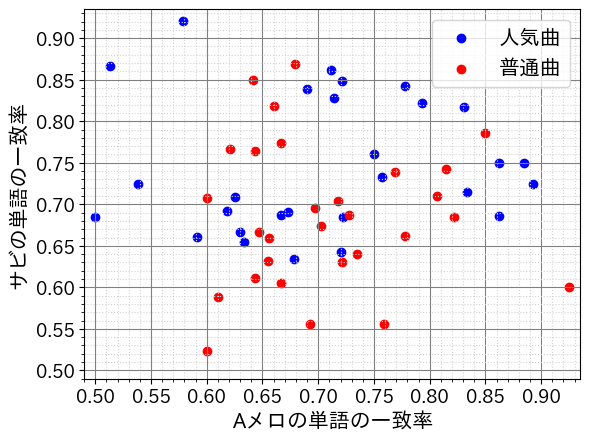

In [14]:
rates_wmr_yoasobi, xy_min_wmr_yoasobi, xy_max_wmr_yoasobi = preprocess(df_yoasobi, "csv/YOASOBI_wmr_20240204.csv")
rates_wmr_yorushika, xy_min_wmr_yorushika, xy_max_wmr_yorushika = preprocess(df_yorushika, "csv/ヨルシカ_wmr_20231119.csv")
rates_wmr_greeeen, xy_min_wmr_greeeen, xy_max_wmr_greeeen = preprocess(df_greeeen, "csv/GReeeeN_wmr_20231119.csv")

df_list = scatter(
    [rates_wmr_greeeen, rates_wmr_yoasobi, rates_wmr_yorushika],
    min(xy_min_wmr_greeeen, xy_min_wmr_yoasobi, xy_min_wmr_yorushika),
    max(xy_max_wmr_greeeen, xy_max_wmr_yoasobi, xy_max_wmr_yorushika),
    ['youtube_url'],
    'youtube_play_times',
    "Aメロの単語の一致率",
    "サビの単語の一致率",
    "images/単語の一致率と楽曲の人気度の関係.svg",
)

## t検定(サビ，軸回転無し)
- 帰無仮説：サビの単語の一致率の平均は等しい
- 有意水準：0.05

In [15]:
sorted_rates = rates_ts.dropna(subset=["youtube_url"]).sort_values("youtube_play_times", ascending=False)
center = len(sorted_rates) // 2
pop_youtube = sorted_rates[:center]
unpop_youtube = sorted_rates[center:]

stats.ttest_ind(df_list[0][RATE_S], df_list[1][RATE_S], equal_var=False)

TtestResult(statistic=2.701937243865395, pvalue=0.009155364566255262, df=54.84569639840552)

# 木構造の類似度

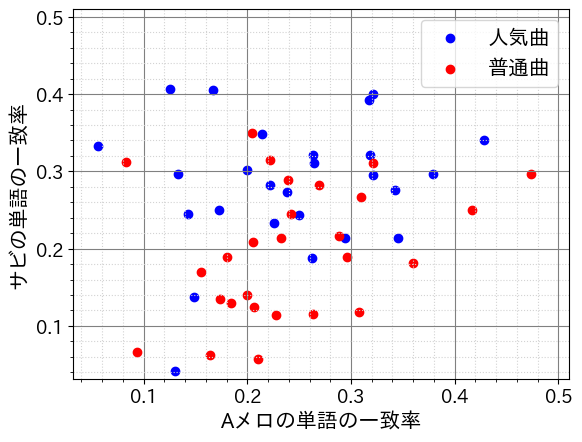

In [16]:
rates_tspc_yoasobi, xy_min_tspc_yoasobi, xy_max_tspc_yoasobi = preprocess(df_yoasobi, "csv/YOASOBI_tspc_20240204.csv")
rates_tspc_yorushika, xy_min_tspc_yorushika, xy_max_tspc_yorushika = preprocess(df_yorushika, "csv/ヨルシカ_tspc_20231119.csv")
rates_tspc_greeeen, xy_min_tspc_greeeen, xy_max_tspc_greeeen = preprocess(df_greeeen, "csv/GReeeeN_tspc_20231119.csv")

df_list = scatter(
    [rates_tspc_greeeen, rates_tspc_yoasobi, rates_tspc_yorushika],
    min(xy_min_tspc_greeeen, xy_min_tspc_yoasobi, xy_min_tspc_yorushika),
   max(xy_max_tspc_greeeen, xy_max_tspc_yoasobi, xy_max_tspc_yorushika),
    ['youtube_url'],
    'youtube_play_times',
    "Aメロの単語の一致率",
    "サビの単語の一致率",
    "images/木構造の類似度と楽曲の人気度の関係.svg",
)

## t検定(サビ，軸回転無し)
- 帰無仮説：サビの単語の一致率の平均は等しい
- 有意水準：0.05

In [17]:
sorted_rates = rates_ts.dropna(subset=["youtube_url"]).sort_values("youtube_play_times", ascending=False)
center = len(sorted_rates) // 2
pop_youtube = sorted_rates[:center]
unpop_youtube = sorted_rates[center:]

stats.ttest_ind(df_list[0][RATE_S], df_list[1][RATE_S], equal_var=False)

TtestResult(statistic=3.6587869431394138, pvalue=0.0006008806154495287, df=50.991817547698155)